In [ ]:
# ================================================================
# Full notebook: Twitter Depression Detection (Kaggle dataset)
# Author: ChatGPT (refactor for user's requirements)
# ================================================================

# --- Install required packages (run once) ---
!pip install -q transformers sentencepiece emoji textblob nltk scikit-learn xgboost torch torchvision tqdm seaborn joblib

# --- Imports ---
import os, re, random, math, warnings, time
import numpy as np, pandas as pd
import emoji
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, BertTokenizer, DistilBertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.sparse import hstack, csr_matrix
import joblib
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

warnings.filterwarnings('ignore')

# -------------------------
# Configuration / Hyperparams
# -------------------------
DATA_PATH = "/content/full_dataset.csv"   # <--- update path if needed
RANDOM_STATE = 42
BATCH_SIZE = 8      # DL batch size (reduce if OOM)
EPOCHS = 5         # DL epochs (10 suggested)
ML_NJOBS = -1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TFIDF_MAX_FEATURES = 20000
PRINT_EVERY = True

print("Device:", DEVICE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 12.5 MB/s eta 0:00:00
Device: cuda


In [ ]:
# -------------------------
# Utility functions
# -------------------------
SLANG_DICT = {
    'lol':'laugh out loud','omg':'oh my god','idk':'i do not know','tbh':'to be honest',
    'btw':'by the way','rn':'right now','smh':'shaking my head','cant':'cannot','dont':'do not',
    'wont':'will not','im':'i am','ive':'i have','ur':'your','u':'you','tho':'though'
}

def clean_text(text):
    if pd.isna(text): return ""
    t = str(text)
    # emojis -> text
    t = emoji.demojize(t, delimiters=(" ", " "))
    t = t.lower()
    # remove urls, mentions, hashtags (keep hashtag words)
    t = re.sub(r'http\S+|www\S+|https\S+', ' ', t)
    t = re.sub(r'@\w+', ' ', t)
    t = re.sub(r'#',' ', t)
    # keep letters and spaces, including Bangla characters (Unicode range \u0980-\u09FF)
    t = re.sub(r'[^a-z\s\u0980-\u09FF]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    # expand slang
    words = [SLANG_DICT.get(w,w) for w in t.split()]
    return ' '.join(words)

def textblob_polarity(text):
    try:
        return TextBlob(text).sentiment.polarity  # [-1,1]
    except:
        return 0.0

def vader_compound_scaled(text):
    try:
        return sia.polarity_scores(text)['compound']  # [-1,1]
    except:
        return 0.0

def scaled_to_0_1(x):
    return (x + 1.0) / 2.0

def psycholinguistic_features(text):
    # simple psycholinguistic / stylistic features extracted from text
    words = text.split()
    wc = len(words)
    avg_word_len = np.mean([len(w) for w in words]) if wc>0 else 0.0
    first_person_count = sum(1 for w in words if w in {'i','me','my','mine','we','us','our'})
    negation_count = sum(1 for w in words if w in {"not","no","never","n't","cannot","cant","won't","wont"})
    emot_count = text.count(':') + text.count(';')  # rough
    return wc, avg_word_len, first_person_count, negation_count, emot_count

In [ ]:
# -------------------------
# 1) Load dataset (auto detect text & label columns)
# -------------------------
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("Initial shape:", df.shape)

# Find text and label columns with improved prioritization
text_col_found = None
label_col_found = None

# Prioritize common text column names, avoiding 'url'
for c_name in ['text', 'tweet_text', 'post_text', 'content_text']:
    if c_name in df.columns:
        text_col_found = c_name
        break

# Fallback if specific names not found, but avoid 'url' in column name
if text_col_found is None:
    for c in df.columns:
        lc = c.lower()
        if ('text' in lc or 'tweet' in lc or 'post' in lc or 'content' in lc) and 'url' not in lc:
            text_col_found = c
            break # Take the first suitable one

# Find label column (prioritizing 'label_gambar' based on previous context, then generic names)
for c_name in ['label', 'target', 'class', 'label_gambar']:
    if c_name in df.columns:
        label_col_found = c_name
        break

if label_col_found is None:
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in ['label','target','class']):
            label_col_found = c
            break

text_col = text_col_found
label_col = label_col_found

assert text_col is not None and label_col is not None, "Cannot detect text/label columns - rename them to include 'text' and 'label' (e.g., 'tweet_text', 'label')."
print("Using text_col =", text_col, "label_col =", label_col)

# drop na
df = df[[text_col, label_col]].rename(columns={text_col:'post_text', label_col:'label'}).dropna().reset_index(drop=True)
print("After select/dropna:", df.shape)

Initial shape: (32363, 26)
Using text_col = full_text label_col = label_gambar
After select/dropna: (32363, 2)


In [ ]:
# -------------------------
# 2) Preprocess + extract sentiment + psycholinguistic features
# -------------------------
print("Preprocessing texts and extracting features...")
df['cleaned_text'] = df['post_text'].apply(clean_text)
# filter out too-short
df = df[df['cleaned_text'].str.split().str.len() >= 3].reset_index(drop=True)
print("Shape after filtering too-short texts:", df.shape)

if df.empty:
    raise ValueError("DataFrame is empty after text cleaning and filtering. Cannot proceed with feature extraction. Please check your data, cleaning function, and filtering criteria.")

# text sentiment features
df['tb_polarity'] = df['cleaned_text'].apply(textblob_polarity)
df['vader_compound'] = df['cleaned_text'].apply(vader_compound_scaled)
# scale to [0,1] to keep non-negative for NB if needed
df['tb_scaled'] = df['tb_polarity'].apply(scaled_to_0_1)
df['vader_scaled'] = df['vader_compound'].apply(scaled_to_0_1)
# psycholinguistic features
df[['word_count','avg_word_len','first_person_count','negation_count','emot_count']] = df['cleaned_text'].apply(
    lambda t: pd.Series(psycholinguistic_features(t))
)
# normalize label to 0/1
def norm_label(x):
    s = str(x).strip().lower()
    if s in {'1','true','yes','depressed','pos','positive'}: return 1
    if s in {'0','false','no','not','not depressed','negative'}: return 0
    try:
        iv = int(float(s))
        return 1 if iv==1 else 0
    except:
        return 0
df['label'] = df['label'].apply(norm_label).astype(int)

print("After cleaning shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())

Preprocessing texts and extracting features...
Shape after filtering too-short texts: (31617, 3)
After cleaning shape: (31617, 12)
Label distribution:
 label
0    29369
1     2248
Name: count, dtype: int64


In [ ]:
# -------------------------
# 3) If single-class or very small, handle (user has Kaggle dataset => should be ok)
# -------------------------
if df['label'].nunique() < 2:
    # HERE: for real project you must get 2 classes; synthetic creation only for debug
    print("⚠️ Only one class present. Please use a dataset with both classes for meaningful training.")
    # Optionally create synthetic minority class for pipeline testing:
    df_fake = df.copy()
    df_fake['label'] = 1
    df_fake['cleaned_text'] = df_fake['cleaned_text'].apply(lambda t: t + " i feel depressed hopeless")
    df = pd.concat([df, df_fake]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    print("Synthetic class added. New distribution:\n", df['label'].value_counts())

# Optionally balance if extremely imbalanced
counts = df['label'].value_counts()
if counts.min() / counts.max() < 0.3:
    print("Upsampling minority class to reduce imbalance...")
    maj = counts.idxmax()
    minr = counts.idxmin()
    df_major = df[df.label==maj]
    df_minor = df[df.label==minr]
    df_minor_up = resample(df_minor, replace=True, n_samples=len(df_major), random_state=RANDOM_STATE)
    df = pd.concat([df_major, df_minor_up]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    print("Balanced distribution:", df['label'].value_counts())


Upsampling minority class to reduce imbalance...
Balanced distribution: label
0    29369
1    29369
Name: count, dtype: int64


In [ ]:
# -------------------------
# 4) Train-test split (stratified)
# -------------------------
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
X_train = X_train.reset_index(drop=True); X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True); y_test = y_test.reset_index(drop=True)
print("Train/test sizes:", len(X_train), len(X_test))
print("Train label counts:\n", y_train.value_counts())


Train/test sizes: 46990 11748
Train label counts:
 label
1    23495
0    23495
Name: count, dtype: int64


In [ ]:
# -------------------------
# 5) ML features: TF-IDF + selected numeric features
# -------------------------
print("Building TF-IDF + numeric features for ML models...")
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Build numeric feature arrays (same order as X_train / X_test)
def numeric_features_series(text_series):
    tb = [textblob_polarity(t) for t in text_series]
    vd = [vader_compound_scaled(t) for t in text_series]
    wc = [psycholinguistic_features(t)[0] for t in text_series]
    avgwl = [psycholinguistic_features(t)[1] for t in text_series]
    fpc = [psycholinguistic_features(t)[2] for t in text_series]
    negc = [psycholinguistic_features(t)[3] for t in text_series]
    emot = [psycholinguistic_features(t)[4] for t in text_series]
    # scale sentiment to [0,1] to avoid negatives when feeding NB (Multinomial)
    tb_s = [(p+1)/2 for p in tb]
    vd_s = [(p+1)/2 for p in vd]
    arr = np.vstack([tb_s, vd_s, wc, avgwl, fpc, negc, emot]).T.astype(np.float32)
    return arr

X_train_num = numeric_features_series(X_train)
X_test_num  = numeric_features_series(X_test)

# Optionally scale numeric features
from sklearn.preprocessing import MinMaxScaler # Changed from StandardScaler
scaler = MinMaxScaler() # Changed from StandardScaler
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled  = scaler.transform(X_test_num)

# Combine sparse TF-IDF and dense numeric into a CSR matrix for ML
X_train_ml = hstack([X_train_tfidf, csr_matrix(X_train_num_scaled)], format='csr')
X_test_ml  = hstack([X_test_tfidf,  csr_matrix(X_test_num_scaled)],  format='csr')
print("ML features shape:", X_train_ml.shape)

Building TF-IDF + numeric features for ML models...
ML features shape: (46990, 20007)


In [ ]:
# ================================================================
# CELL 6 — Train ML Models (Logistic Regression, Linear SVM, Naive Bayes)
# + Soft Voting Ensemble
# ================================================================
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("="*70)
print("STEP 6: MACHINE LEARNING MODELS + SOFT VOTING ENSEMBLE")
print("="*70)

# Ensure X_train_ml and X_test_ml have no negative values for MultinomialNB
# This ensures robustness even with potential floating point inaccuracies from TF-IDF.
X_train_ml.data = np.maximum(X_train_ml.data, 0)
X_test_ml.data  = np.maximum(X_test_ml.data, 0)

# -------------------------
# 1️⃣ Define Models
# -------------------------
lr_model = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    solver='saga',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

svm_model = SGDClassifier(
    loss='hinge',
    class_weight='balanced',
    random_state=RANDOM_STATE
)

nb_model = MultinomialNB(alpha=0.1)

# -------------------------
# 2️⃣ Train individual models
# -------------------------
print("\nTraining Logistic Regression and SVM...")
lr_model.fit(X_train_ml, y_train)
svm_model.fit(X_train_ml, y_train)

# Naive Bayes can now be trained directly on the already-clamped X_train_ml
print("Training Naive Bayes...")
nb_model.fit(X_train_ml, y_train)

# -------------------------
# 3️⃣ Calibrate SVM for probability outputs (needed for soft voting)
# -------------------------
print("\nCalibrating Linear SVM (for soft voting)...")
svm_calibrated = CalibratedClassifierCV(svm_model, cv=3)
svm_calibrated.fit(X_train_ml, y_train)

# -------------------------
# 4️⃣ Create ML Ensemble (Soft Voting)
# -------------------------
ml_ensemble = VotingClassifier(
    estimators=[('lr', lr_model), ('svm', svm_calibrated), ('nb', nb_model)],
    voting='soft',
    weights=[0.4, 0.4, 0.2],
    n_jobs=-1
)
print("\nTraining ML Ensemble (Soft Voting)...")
ml_ensemble.fit(X_train_ml, y_train)

# -------------------------
# 5️⃣ Evaluation Function
# -------------------------
def eval_ml_model(model, X, y_true, name):
    preds = model.predict(X)
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    prec = precision_score(y_true, preds)
    rec = recall_score(y_true, preds)
    print(f"{name}: acc={acc:.4f} | f1={f1:.4f} | prec={prec:.4f} | rec={rec:.4f}")
    return acc, f1, prec, rec

# -------------------------
# 6️⃣ Evaluate All Models
# -------------------------
print("\nEVALUATION RESULTS (Test Set):")
lr_acc, lr_f1, lr_prec, lr_rec = eval_ml_model(lr_model, X_test_ml, y_test, "Logistic Regression")
svm_acc, svm_f1, svm_prec, svm_rec = eval_ml_model(svm_calibrated, X_test_ml, y_test, "Linear SVM")
nb_acc, nb_f1, nb_prec, nb_rec = eval_ml_model(nb_model, X_test_ml, y_test, "Naive Bayes")
ml_acc, ml_f1, ml_prec, ml_rec = eval_ml_model(ml_ensemble, X_test_ml, y_test, "ML Ensemble (Soft Voting)")

# -------------------------
# 7️⃣ Store ML Probabilities for Stacking
# -------------------------
ml_train_probs = ml_ensemble.predict_proba(X_train_ml)
ml_test_probs  = ml_ensemble.predict_proba(X_test_ml)
print("\nML probs shapes — train:", ml_train_probs.shape, "test:", ml_test_probs.shape)

# -------------------------
# 8️⃣ Display Summary
# -------------------------
import pandas as pd
ml_summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVM", "Naive Bayes", "ML Ensemble"],
    "Accuracy": [lr_acc, svm_acc, nb_acc, ml_acc],
    "F1-Score": [lr_f1, svm_f1, nb_f1, ml_f1],
    "Precision": [lr_prec, svm_prec, nb_prec, ml_prec],
    "Recall": [lr_rec, svm_rec, nb_rec, ml_rec]
})
print("\nML Performance Summary:")
display(ml_summary)

STEP 6: MACHINE LEARNING MODELS + SOFT VOTING ENSEMBLE

Training Logistic Regression and SVM...
Training Naive Bayes...

Calibrating Linear SVM (for soft voting)...

Training ML Ensemble (Soft Voting)...

EVALUATION RESULTS (Test Set):
Logistic Regression: acc=0.9121 | f1=0.9147 | prec=0.8882 | rec=0.9428
Linear SVM: acc=0.8910 | f1=0.8907 | prec=0.8928 | rec=0.8887
Naive Bayes: acc=0.8550 | f1=0.8423 | prec=0.9227 | rec=0.7748
ML Ensemble (Soft Voting): acc=0.8974 | f1=0.8969 | prec=0.9012 | rec=0.8927

ML probs shapes — train: (46990, 2) test: (11748, 2)

ML Performance Summary:


,Model,Accuracy,F1-Score,Precision,Recall
0,Logistic Regression,0.912070,0.914692,0.888212,0.942799
1,Linear SVM,0.890960,0.890709,0.892766,0.888662
2,Naive Bayes,0.854954,0.842310,0.922749,0.774770
3,ML Ensemble,0.897429,0.896947,0.901186,0.892748


In [ ]:
# -------------------------
# 7) Deep Learning: dataset class, models, training utilities
# -------------------------
print("Preparing DL tokenizers, dataset and models...")
# Tokenizers
bertweet_name = "vinai/bertweet-base"
bert_name = "bert-base-uncased"
distil_name = "distilbert-base-uncased"

tok_bt = AutoTokenizer.from_pretrained(bertweet_name, normalization=True)
tok_bert = BertTokenizer.from_pretrained(bert_name)
tok_dist = DistilBertTokenizer.from_pretrained(distil_name)

class DepressionDatasetTorch(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels': torch.tensor(int(self.labels[idx]), dtype=torch.long)
        }

# Models
class TransformerClassifier(nn.Module):
    def __init__(self, backbone_name, hidden_size=768, dropout=0.3):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(backbone_name)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 2)
    def forward(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        # use CLS token embedding (last_hidden_state[:,0,:])
        hidden = out.last_hidden_state[:,0,:]
        return self.fc(self.dropout(hidden))

class BERTBiLSTMAttention(nn.Module):
    def __init__(self, bert_name='bert-base-uncased', hidden_size=256, num_layers=1, dropout=0.3):
        super().__init__()
        from transformers import BertModel
        self.bert = BertModel.from_pretrained(bert_name)
        self.lstm = nn.LSTM(768, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.attn = nn.Linear(hidden_size*2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, 2)
    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        lstm_out, _ = self.lstm(bert_out)
        attn_w = torch.softmax(self.attn(lstm_out), dim=1)  # shape (batch, seq, 1)
        context = torch.sum(attn_w * lstm_out, dim=1)
        return self.fc(self.dropout(context))

# DataLoaders
train_dataset_bt = DepressionDatasetTorch(X_train, y_train, tok_bt, max_len=128)
test_dataset_bt  = DepressionDatasetTorch(X_test,  y_test,  tok_bt, max_len=128)
train_dataset_bert = DepressionDatasetTorch(X_train, y_train, tok_bert, max_len=128)
test_dataset_bert  = DepressionDatasetTorch(X_test,  y_test,  tok_bert, max_len=128)
train_dataset_dist = DepressionDatasetTorch(X_train, y_train, tok_dist, max_len=128)
test_dataset_dist  = DepressionDatasetTorch(X_test,  y_test,  tok_dist, max_len=128)

train_loader_bt = DataLoader(train_dataset_bt, batch_size=BATCH_SIZE, shuffle=True)
test_loader_bt  = DataLoader(test_dataset_bt,  batch_size=BATCH_SIZE)
train_loader_bert = DataLoader(train_dataset_bert, batch_size=BATCH_SIZE, shuffle=True)
test_loader_bert  = DataLoader(test_dataset_bert, batch_size=BATCH_SIZE)
train_loader_dist = DataLoader(train_dataset_dist, batch_size=BATCH_SIZE, shuffle=True)
test_loader_dist  = DataLoader(test_dataset_dist, batch_size=BATCH_SIZE)

# Training functions
def train_epoch(model, dataloader, optimizer, scheduler, loss_fn):
    model.train()
    losses = []
    preds, labs = [], []
    for batch in tqdm(dataloader, desc="Train", leave=False):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        losses.append(loss.item())
        preds.extend(torch.argmax(logits, dim=1).detach().cpu().numpy().tolist())
        labs.extend(labels.detach().cpu().numpy().tolist())
    return np.mean(losses), accuracy_score(labs, preds)

def eval_model_torch(model, dataloader, loss_fn):
    model.eval()
    losses = []
    preds, labs = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            losses.append(loss.item())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())
            labs.extend(labels.cpu().numpy().tolist())
    return np.mean(losses), accuracy_score(labs, preds), preds, labs

def train_model_torch(model, train_loader, val_loader, name, epochs=EPOCHS, lr=2e-5):
    model.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(train_loader) * epochs
    warmup_steps = max(1, total_steps // 10)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    best_acc = 0.0
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(epochs):
        print(f"[{name}] Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, loss_fn)
        val_loss, val_acc, _, _ = eval_model_torch(model, val_loader, loss_fn)
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        print(f"  Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{name}_best.pt")
            print("  -> Saved best model.")
    # load best
    model.load_state_dict(torch.load(f"{name}_best.pt"))
    return model, history


Preparing DL tokenizers, dataset and models...


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# -------------------------
# 8) Train DL models (BERT-BiLSTM-Attention, BERTweet, DistilBERT)
# -------------------------
print("Training deep models (this will take time on CPU; use GPU).")
# initialize models
bertbilstm = BERTBiLSTMAttention(bert_name).to(DEVICE)
bertbilstm, history_b = train_model_torch(bertbilstm, train_loader_bert, test_loader_bert, "bert_bilstm", epochs=EPOCHS)

bertweet = TransformerClassifier(bertweet_name).to(DEVICE)
bertweet, history_bt = train_model_torch(bertweet, train_loader_bt, test_loader_bt, "bertweet", epochs=EPOCHS)

distil = TransformerClassifier(distil_name).to(DEVICE)
distil, history_d = train_model_torch(distil, train_loader_dist, test_loader_dist, "distilbert", epochs=EPOCHS)


Training deep models (this will take time on CPU; use GPU).


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[bert_bilstm] Epoch 1/5


  Train loss 0.5636 acc 0.7027 | Val loss 0.3071 acc 0.8803
  -> Saved best model.
[bert_bilstm] Epoch 2/5


  Train loss 0.2677 acc 0.9237 | Val loss 0.1517 acc 0.9667
  -> Saved best model.
[bert_bilstm] Epoch 3/5


  Train loss 0.1132 acc 0.9750 | Val loss 0.1876 acc 0.9664
[bert_bilstm] Epoch 4/5


  Train loss 0.0566 acc 0.9886 | Val loss 0.0921 acc 0.9838
  -> Saved best model.
[bert_bilstm] Epoch 5/5


  Train loss 0.0296 acc 0.9940 | Val loss 0.0927 acc 0.9850
  -> Saved best model.


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

[bertweet] Epoch 1/5


Train:   0%|          | 0/5874 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

  Train loss 0.6263 acc 0.6382 | Val loss 0.4679 acc 0.7837
  -> Saved best model.
[bertweet] Epoch 2/5


  Train loss 0.3680 acc 0.8628 | Val loss 0.2569 acc 0.9304
  -> Saved best model.
[bertweet] Epoch 3/5


  Train loss 0.2083 acc 0.9447 | Val loss 0.1860 acc 0.9574
  -> Saved best model.
[bertweet] Epoch 4/5


  Train loss 0.1184 acc 0.9728 | Val loss 0.2413 acc 0.9528
[bertweet] Epoch 5/5


  Train loss 0.0613 acc 0.9873 | Val loss 0.2036 acc 0.9654
  -> Saved best model.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

[distilbert] Epoch 1/5


  Train loss 0.5656 acc 0.6941 | Val loss 0.3348 acc 0.8577
  -> Saved best model.
[distilbert] Epoch 2/5


  Train loss 0.2708 acc 0.9178 | Val loss 0.2336 acc 0.9393
  -> Saved best model.
[distilbert] Epoch 3/5


  Train loss 0.1266 acc 0.9718 | Val loss 0.1235 acc 0.9741
  -> Saved best model.
[distilbert] Epoch 4/5


  Train loss 0.0608 acc 0.9870 | Val loss 0.1205 acc 0.9791
  -> Saved best model.
[distilbert] Epoch 5/5


  Train loss 0.0346 acc 0.9931 | Val loss 0.1481 acc 0.9760


In [ ]:
# -------------------------
# 9) Get DL probabilities for train & test for stacking
# -------------------------
def get_probs(model, dataloader):
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Get probs", leave=False):
            ids = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            out = model(ids, mask)
            p = torch.softmax(out, dim=1).cpu().numpy()
            probs.append(p)
    return np.vstack(probs)

bt_train_probs = get_probs(bertweet, train_loader_bt)
bt_test_probs  = get_probs(bertweet, test_loader_bt)
bb_train_probs = get_probs(bertbilstm, train_loader_bert)
bb_test_probs  = get_probs(bertbilstm, test_loader_bert)
dist_train_probs= get_probs(distil, train_loader_dist)
dist_test_probs = get_probs(distil, test_loader_dist)

# DL ensemble (weighted by validation accuracy optionally)
acc_bt = accuracy_score(y_test, np.argmax(bt_test_probs, axis=1))
acc_bb = accuracy_score(y_test, np.argmax(bb_test_probs, axis=1))
acc_dist = accuracy_score(y_test, np.argmax(dist_test_probs, axis=1))
accs = np.array([acc_bt, acc_bb, acc_dist])
if accs.sum() == 0:
    weights = np.array([1/3,1/3,1/3])
else:
    weights = np.exp(accs) / np.exp(accs).sum()
print("DL model accuracies (test):", acc_bt, acc_bb, acc_dist, " => weights:", weights)

dl_train_probs = weights[0]*bt_train_probs + weights[1]*bb_train_probs + weights[2]*dist_train_probs
dl_test_probs  = weights[0]*bt_test_probs  + weights[1]*bb_test_probs  + weights[2]*dist_test_probs

dl_preds = np.argmax(dl_test_probs, axis=1)
print("DL ensemble acc:", accuracy_score(y_test, dl_preds), "f1:", f1_score(y_test, dl_preds))

DL model accuracies (test): 0.9654409261150834 0.9850187265917603 0.9790602655771196  => weights: [0.32965404 0.33617153 0.33417442]
DL ensemble acc: 0.9875723527408921 f1: 0.9877207737594618


In [ ]:
# -------------------------
# 11) Live prediction function
# -------------------------
def predict_live(text, verbose=True):
    cleaned = clean_text(text)
    if len(cleaned.split()) < 3:
        return {"error":"Text too short (min 3 words)."}
    # ML part
    tfv = tfidf.transform([cleaned])
    numeric = numeric_features_series([cleaned])
    numeric_scaled = scaler.transform(numeric)
    X_ml = hstack([tfv, csr_matrix(numeric_scaled)], format='csr')
    ml_prob = ml_ensemble.predict_proba(X_ml)[0]
    # DL encodings
    enc_bt = tok_bt(cleaned, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    enc_bert = tok_bert(cleaned, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    enc_dist = tok_dist(cleaned, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    bertweet.eval(); bertbilstm.eval(); distil.eval()
    with torch.no_grad():
        bt_out = bertweet(enc_bt['input_ids'].to(DEVICE), enc_bt['attention_mask'].to(DEVICE))
        bb_out = bertbilstm(enc_bert['input_ids'].to(DEVICE), enc_bert['attention_mask'].to(DEVICE))
        ds_out = distil(enc_dist['input_ids'].to(DEVICE), enc_dist['attention_mask'].to(DEVICE))
        bt_p = torch.softmax(bt_out, dim=1).cpu().numpy()[0]
        bb_p = torch.softmax(bb_out, dim=1).cpu().numpy()[0]
        ds_p = torch.softmax(ds_out, dim=1).cpu().numpy()[0]
    dl_p = weights[0]*bt_p + weights[1]*bb_p + weights[2]*ds_p
    stacked = np.hstack([ml_prob, dl_p]).reshape(1, -1)
    final_proba = meta.predict_proba(stacked)[0][1]*100
    final_pred = meta.predict(stacked)[0]
    label = "DEPRESSED" if final_pred==1 else "NOT DEPRESSED"
    breakdown = {
        'ml_depressed_pct': ml_prob[1]*100,
        'dl_depressed_pct': dl_p[1]*100,
        'bertweet_pct': bt_p[1]*100,
        'bert_bilstm_pct': bb_p[1]*100,
        'distil_pct': ds_p[1]*100,
        'final_confidence_pct': final_proba
    }
    if verbose:
        print("\n" + "="*60)
        print("INPUT:", text)
        print("CLEANED:", cleaned)
        print(f"PREDICTION: {label}   (Confidence: {final_proba:.2f}%)")
        print("Breakdown:", breakdown)
        print("="*60 + "\n")
    return {'label': label, 'confidence': final_proba, 'breakdown': breakdown}

# Example:
# res = predict_live("I'm feeling hopeless and alone every day.")
# print(res)

# End of notebook


STEP 11: STACKING META-LEARNER (FUSION OF ML + DL MODELS)
Preparing stacking features and training meta-learner...
Stack shapes — train: (46990, 4) test: (11748, 4)
LogisticRegression -> acc:0.8957 f1:0.8954 auc:0.9595
XGBoost -> acc:0.9011 f1:0.9012 auc:0.9633

Selected meta-learner: XGBoost

STACKING RESULT -> acc=0.9011 | f1=0.9012 | auc=0.9633

Classification report (stacking):
              precision    recall  f1-score   support

           0     0.9018    0.9002    0.9010      5874
           1     0.9004    0.9019    0.9012      5874

    accuracy                         0.9011     11748
   macro avg     0.9011    0.9011    0.9011     11748
weighted avg     0.9011    0.9011    0.9011     11748



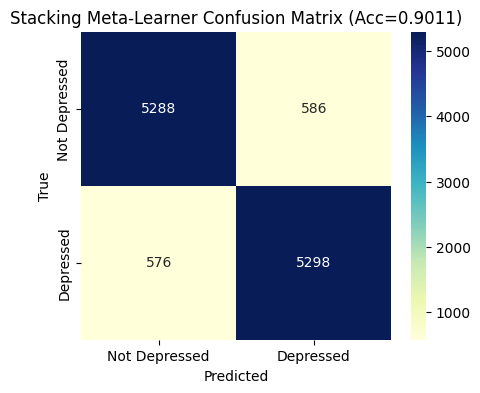

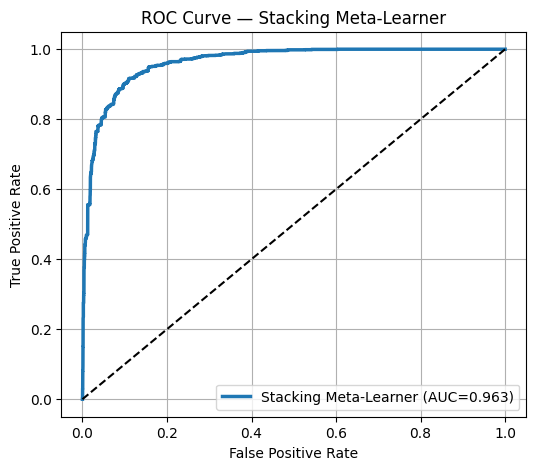

In [ ]:
# ================================================================
# CELL 11 — STACKING META-LEARNER (FUSION OF ML + DL MODELS)
# ================================================================
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

print("="*70)
print("STEP 11: STACKING META-LEARNER (FUSION OF ML + DL MODELS)")
print("="*70)

# -------------------------
# 1️⃣ Stack ML + DL probabilities
# -------------------------
print("Preparing stacking features and training meta-learner...")

X_train_stack = np.hstack([ml_train_probs, dl_train_probs])
X_test_stack  = np.hstack([ml_test_probs, dl_test_probs])

print("Stack shapes — train:", X_train_stack.shape, "test:", X_test_stack.shape)

# -------------------------
# 2️⃣ Train Meta Learners
# -------------------------
meta_lr = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced', random_state=RANDOM_STATE)
meta_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

meta_lr.fit(X_train_stack, y_train)
meta_xgb.fit(X_train_stack, y_train)

# -------------------------
# 3️⃣ Evaluate Meta Learners
# -------------------------
for name, model in [('LogisticRegression', meta_lr), ('XGBoost', meta_xgb)]:
    preds = model.predict(X_test_stack)
    probs = model.predict_proba(X_test_stack)[:,1]
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)
    print(f"{name} -> acc:{acc:.4f} f1:{f1:.4f} auc:{auc:.4f}")

# -------------------------
# 4️⃣ Pick Best Meta-Learner
# -------------------------
stack_acc_lr = accuracy_score(y_test, meta_lr.predict(X_test_stack))
stack_f1_lr  = f1_score(y_test, meta_lr.predict(X_test_stack))
stack_auc_lr = roc_auc_score(y_test, meta_lr.predict_proba(X_test_stack)[:,1])

stack_acc_xgb = accuracy_score(y_test, meta_xgb.predict(X_test_stack))
stack_f1_xgb  = f1_score(y_test, meta_xgb.predict(X_test_stack))
stack_auc_xgb = roc_auc_score(y_test, meta_xgb.predict_proba(X_test_stack)[:,1])

if stack_acc_lr >= stack_acc_xgb:
    meta_final = meta_lr
    print("\nSelected meta-learner: LogisticRegression")
    stack_acc, stack_f1, stack_auc = stack_acc_lr, stack_f1_lr, stack_auc_lr
else:
    meta_final = meta_xgb
    print("\nSelected meta-learner: XGBoost")
    stack_acc, stack_f1, stack_auc = stack_acc_xgb, stack_f1_xgb, stack_auc_xgb

print(f"\nSTACKING RESULT -> acc={stack_acc:.4f} | f1={stack_f1:.4f} | auc={stack_auc:.4f}")

# -------------------------
# 5️⃣ Classification Report
# -------------------------
stack_preds = meta_final.predict(X_test_stack)
print("\nClassification report (stacking):")
print(classification_report(y_test, stack_preds, digits=4))

# -------------------------
# 6️⃣ Confusion Matrix & ROC Visualization
# -------------------------
cm = confusion_matrix(y_test, stack_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title(f'Stacking Meta-Learner Confusion Matrix (Acc={stack_acc:.4f})')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

fpr, tpr, _ = roc_curve(y_test, meta_final.predict_proba(X_test_stack)[:,1])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Stacking Meta-Learner (AUC={stack_auc:.3f})', linewidth=2.5)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Stacking Meta-Learner')
plt.legend()
plt.grid(True)
plt.show()